In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
from utils import (
    to_dates,
    get_spot_rates
)
import QuantLib as ql
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

In [2]:
depo_maturities = [ql.Period(6, ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.50]

# Bond rates
bond_maturities = [ql.Period(6 * i, ql.Months) for i in range(3, 21)]
bond_rates = [5.75, 6.00, 6.25, 6.50, 6.75, 6.80, 7.00, 7.10, 7.15, 7.20, 7.30,
              7.35, 7.40, 7.50, 7.60, 7.60, 7.70, 7.80]

maturities = depo_maturities + bond_maturities
rates = depo_rates + bond_rates
pd.DataFrame(list(zip(maturities, rates)),
             columns=["Maturity", "Curve"],
             index=['']*len(rates))

,Maturity,Curve
,6M,5.25
,1Y,5.50
,1Y6M,5.75
,2Y,6.00
,2Y6M,6.25
,3Y,6.50
,3Y6M,6.75
,4Y,6.80
,4Y6M,7.00
,5Y,7.10


In [3]:
calc_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates()
business_convention = ql.Unadjusted
day_count = ql.Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)

In [4]:
depo_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r / 100.)),
                         m,
                         settlement_days,
                         calendar,
                         business_convention,
                         end_of_month,
                         day_count)
    for r, m in zip(depo_rates, depo_maturities)
]

In [5]:
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(calc_date,
                           termination_date,
                           coupon_frequency,
                           calendar,
                           business_convention,
                           business_convention,
                           ql.DateGeneration.Backward,
                           end_of_month)
    bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                         settlement_days,
                                         face_amount,
                                         schedule,
                                         [r / 100.0],
                                         day_count,
                                         business_convention)
    bond_helpers.append(bond_helper)

In [6]:
rate_helpers = depo_helpers + bond_helpers

In [9]:
yc_logcubicdiscount = ql.PiecewiseLogCubicDiscount(calc_date,
                                                   rate_helpers,
                                                   day_count)
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
splcd.tail()

,Maturity,Curve
,9.666667,7.981384
,9.750000,8.005292
,9.833333,8.028145
,9.916667,8.050187
,10.000000,8.071649


In [11]:
yc_linearzero = ql.PiecewiseLinearZero(calc_date, rate_helpers, day_count)
splz = get_spot_rates(yc_linearzero, day_count)
splz.tail()

,Maturity,Curve
,9.666667,7.976804
,9.750000,8.000511
,9.833333,8.024221
,9.916667,8.047934
,10.000000,8.071649


In [12]:
yc_cubiczero = ql.PiecewiseCubicZero(calc_date, rate_helpers, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
spcz.tail()

,Maturity,Curve
,9.666667,7.976469
,9.750000,8.000172
,9.833333,8.023953
,9.916667,8.047787
,10.000000,8.071649


(5.25, 8.0)

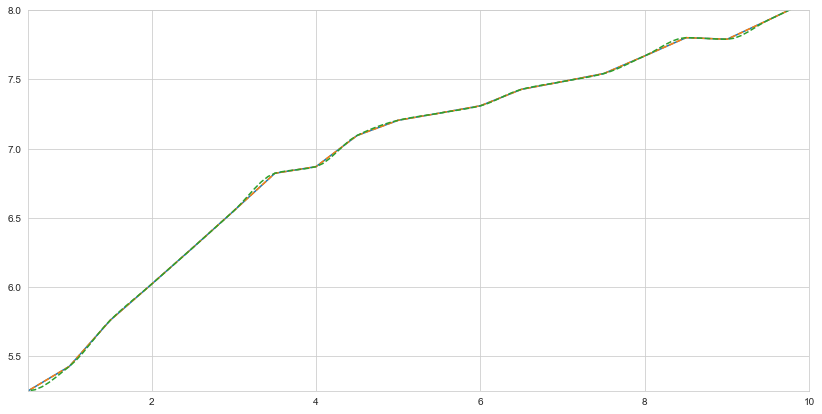

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(splcd["Maturity"], splcd["Curve"], label="LogCubicDiscount")
plt.plot(splz["Maturity"], splz["Curve"], "--", label="LinearZero")
plt.plot(spcz["Maturity"], spcz["Curve"], "--", label="CubicZero")
plt.xlim((0.5, 10))
plt.ylim((5.25, 8.00))